# Unsupervisws Morphological Analysis 

- English
    - https://www.thoughtco.com/common-prefixes-in-english-1692724
    - https://www.learnenglish.de/grammar/prefixtext.html
    - https://www.thoughtco.com/common-suffixes-in-english-1692725
    - https://www.learnenglish.de/grammar/suffixtext.html
    - https://englishstudyonline.org/suffix/
    - https://www.learnthat.org/pages/view/suffix.html
- Russian


In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']


from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *

In [2]:
#get raw lexicon list
ru_lex = list(pd.read_csv("https://raw.githubusercontent.com/aigents/aigents-java/master/lexicon_russian.txt",sep='\t',header=None,na_filter=False).to_records(index=False))
print(len(ru_lex))

#debug raw lexicon
print(max(ru_lex,key=lambda item:item[1]))
ru_lex_dict = weightedlist2dict(ru_lex,lower=True) # no case-insensitive merge
print(len(ru_lex_dict))


99983
('не', 3164900)
91379


In [3]:
#get raw lexicon list
en_lex = list(pd.read_csv("https://raw.githubusercontent.com/aigents/aigents-java/master/lexicon_english.txt",sep='\t',header=None,na_filter=False).to_records(index=False))
print(len(en_lex))

#debug raw lexicon
print(max(en_lex,key=lambda item:item[1]))
en_lex_dict = weightedlist2dict(en_lex,lower=True) # no case-insensitive merge
print(len(en_lex_dict))


97565
('the', 53097401)
97565


91379
98020


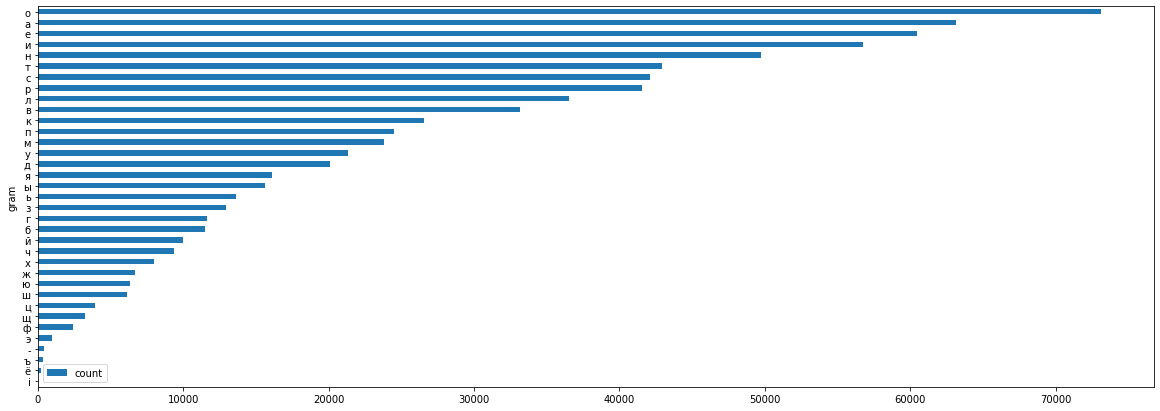

In [4]:
ru_lex_texts_no_count = list(ru_lex_dict)
print(len(ru_lex_texts_no_count))
lex_ru_base = FreedomTokenizer(max_n=3,mode='chars',debug=False)
lex_ru_base.train(ru_lex_texts_no_count)
print(lex_ru_base.count_params())
dic = dict([(key,lex_ru_base.model[0][key]) for key in lex_ru_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')


97565
112334


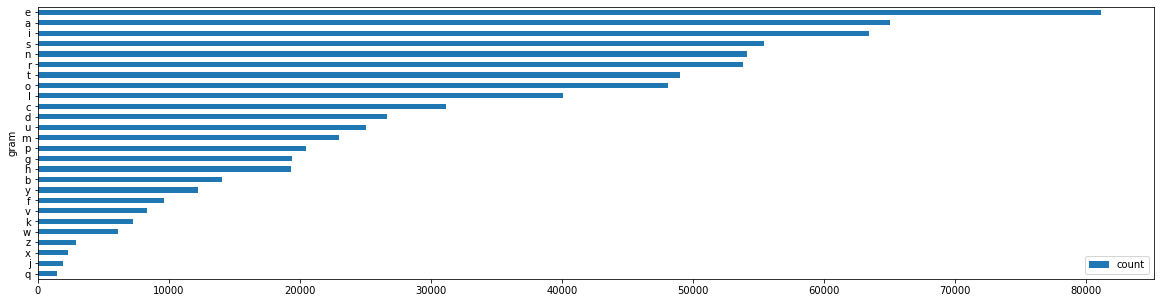

In [5]:
en_lex_texts_no_count = list(en_lex_dict)
print(len(en_lex_texts_no_count))
lex_en_base = FreedomTokenizer(max_n=3,mode='chars',debug=False)
lex_en_base.train(en_lex_texts_no_count)
print(lex_en_base.count_params())
dic = dict([(key,lex_en_base.model[0][key]) for key in lex_en_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')


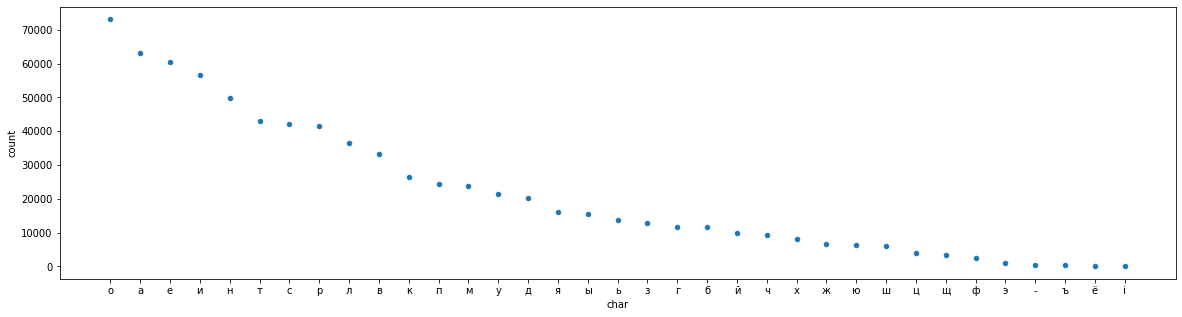

In [6]:
l = sorted([(key,lex_ru_base.model[0][key]) for key in lex_ru_base.model[0] if len(key) == 1],key=lambda x: x[1])
l.reverse()
df = pd.DataFrame(l,columns=['char','count'])
p = df.plot.scatter(x='char',y='count')


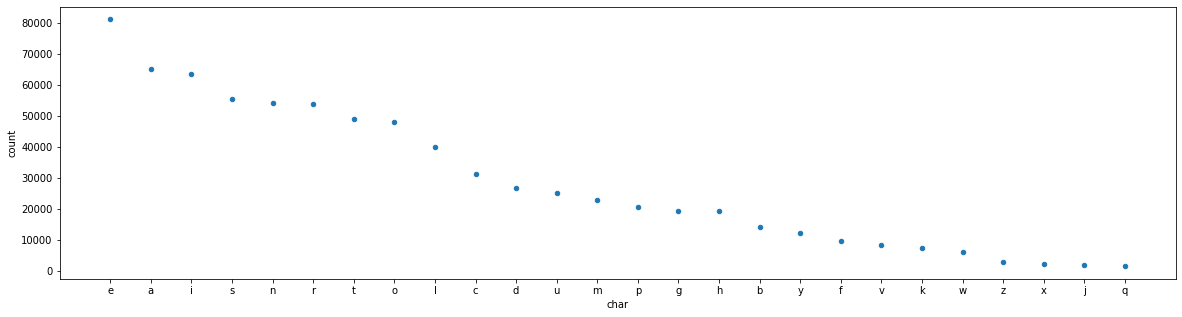

In [7]:
l = sorted([(key,lex_en_base.model[0][key]) for key in lex_en_base.model[0] if len(key) == 1],key=lambda x: x[1])
l.reverse()
df = pd.DataFrame(l,columns=['char','count'])
p = df.plot.scatter(x='char',y='count')


In [15]:
def load_word_set(path,words=None):
    print(path)
    if path.lower().startswith('http'):
        lines = url_text_lines(path)
    else:
        with open(path,errors='ignore') as f:
            lines = f.readlines()
    if words is None:
        words = set()
    for l in lines:
        s = l.strip()
        if len(s) > 0:
            words.add(s)
    return words

def load_word_list_reverse(path,words=None):
    words = sorted(load_word_set(path), key=len)
    words.reverse()
    return words

class PrefixSuffixMorphoTokenizer(Tokenizer):
    def __init__(self,prefixes,suffixes):
        Tokenizer.__init__(self,debug=False)
        self.prefixes = [load_word_list_reverse(path) for path in prefixes]
        self.suffixes = [load_word_list_reverse(path) for path in suffixes]
        
    def tokenize(self,text):
        all_prefixes = []
        for prefixes in self.prefixes:
            for prefix in prefixes:
                if len(text) > len(prefix) and text.startswith(prefix):
                    all_prefixes.append(prefix)
                    text = text[len(prefix):]
                    break
        all_suffixes = []
        for suffixes in self.suffixes:
            for suffix in suffixes:
                if len(text) > len(suffix) and text.endswith(suffix):
                    all_suffixes.append(suffix)
                    text = text[:len(text)-len(suffix)]
                    break
        all_suffixes.reverse()
        return all_prefixes + [text] + all_suffixes


In [22]:
class PrefixSuffixMorphoTokenizerCached(PrefixSuffixMorphoTokenizer):
    def __init__(self,prefixes,suffixes):
        PrefixSuffixMorphoTokenizer.__init__(self,prefixes,suffixes)
        self.cache = {}

    def tokenize(self,text):
        if text in self.cache:
            #print(text, '-cache->', self.cache[text])
            return self.cache[text]
        pieces = PrefixSuffixMorphoTokenizer.tokenize(self,text)
        self.cache[text] = pieces
        #print(text, '-tokenize->', pieces)
        return pieces


In [23]:
en_ref_tokenizer = PrefixSuffixMorphoTokenizerCached(["https://raw.githubusercontent.com/aigents/pygents/master/data/corpora/English/morphology/prefixes.txt"],
                                   ["https://raw.githubusercontent.com/aigents/pygents/master/data/corpora/English/morphology/suffixes.txt"])


https://raw.githubusercontent.com/aigents/pygents/master/data/corpora/English/morphology/prefixes.txt
https://raw.githubusercontent.com/aigents/pygents/master/data/corpora/English/morphology/suffixes.txt


In [24]:
en_ref_tokenizer.tokenize('subsidiary')
en_ref_tokenizer.tokenize('subsidiary')

['sub', 'sidi', 'ary']

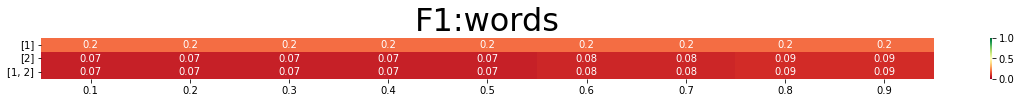

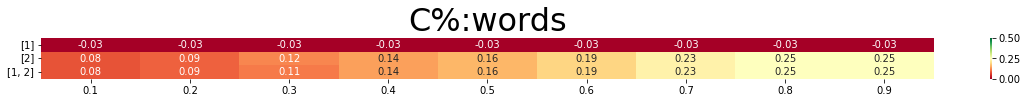

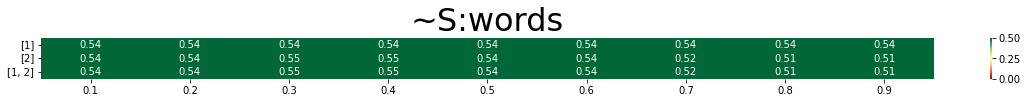

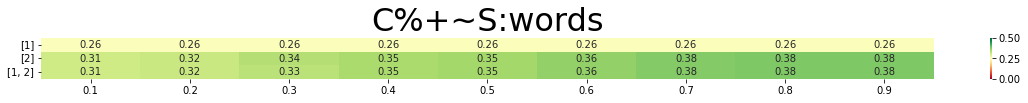

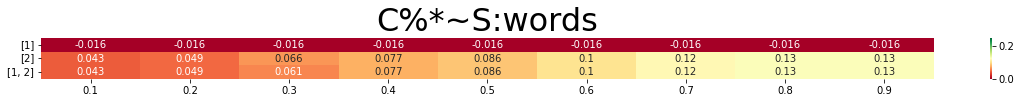

NameError: name 'metric_list' is not defined

In [27]:
model_threshold = 0
ngram_params = [[1],[2],[1,2]] #TODO 3
token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#ngram_params = [[1],[2]] #TODO 3
#token_thresholds = [0.1,0.3,0.5,0.7,0.9]
title = 'Morphology'
metrics = evaluate_freedom_tokenizer_multimetrics(en_lex_texts_no_count,en_ref_tokenizer,
    FreedomBasedTokenizer(lex_en_base,'dvf-','dvf+'),
    ngram_params,token_thresholds,title="words".format(title,model_threshold),crossmetrics=True)
metric_list.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])


ref 	 auto
['govern', 'ment'] 	 ['g', 'overnment']
['uni', 'vers', 'ity'] 	 ['universi', 'ty']
['especial', 'ly'] 	 ['especial', 'ly']
['manage', 'ment'] 	 ['man', 'ag', 'ement']
['particular', 'ly'] 	 ['particular', 'ly']
['organ', 'ization'] 	 ['o', 'rg', 'an', 'iz', 'ation']
['signific', 'ant'] 	 ['s', 'ig', 'nificant']
['everyth', 'ing'] 	 ['eve', 'ry', 'thi', 'ng']
['un', 'derstand', 'ing'] 	 ['understandi', 'ng']
['washington'] 	 ['wa', 'shi', 'ng', 'ton']
['throughout'] 	 ['thro', 'ug', 'hout']


/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


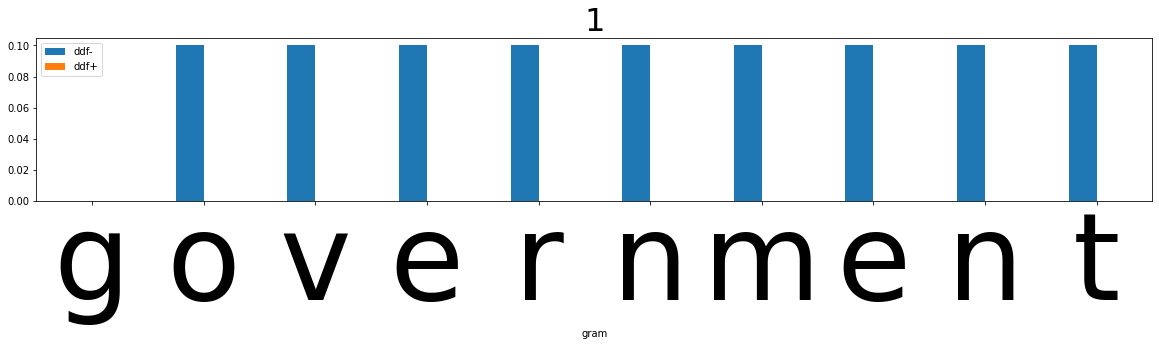

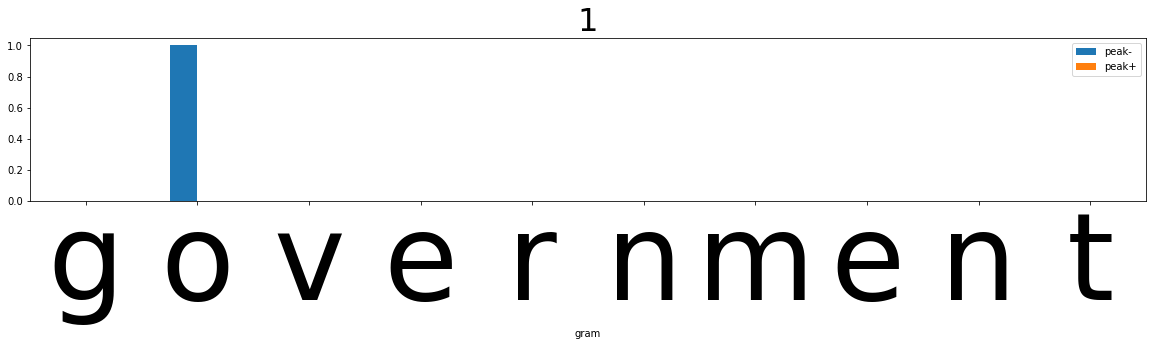

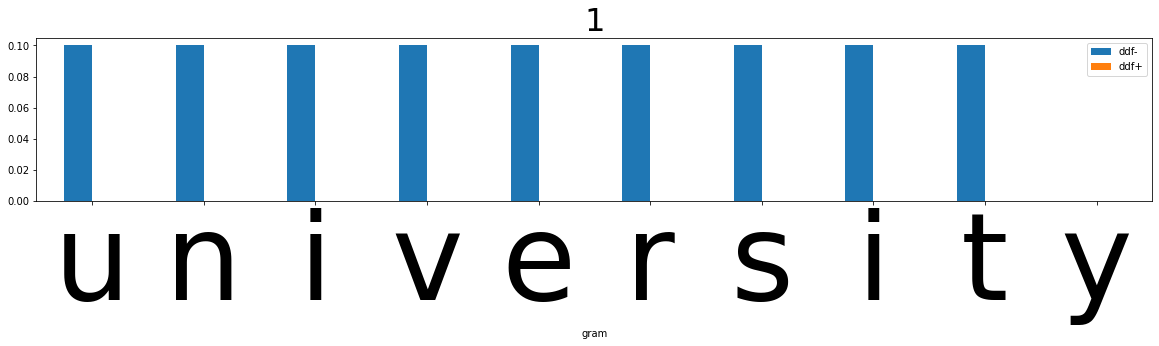

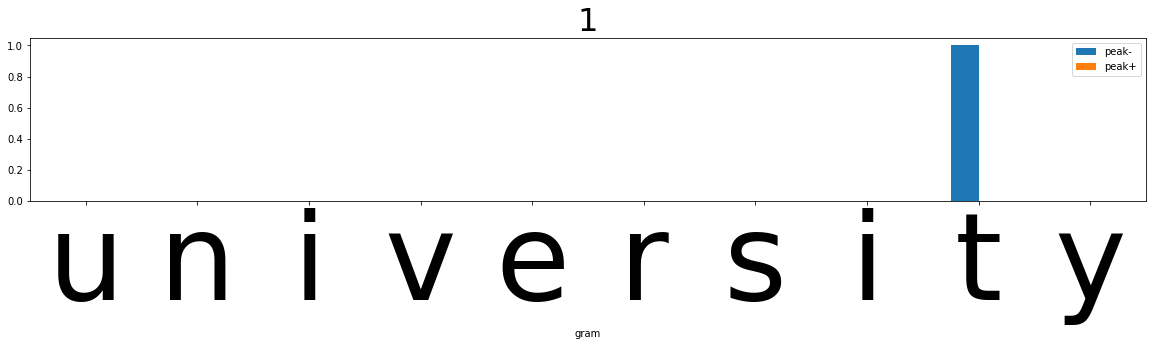

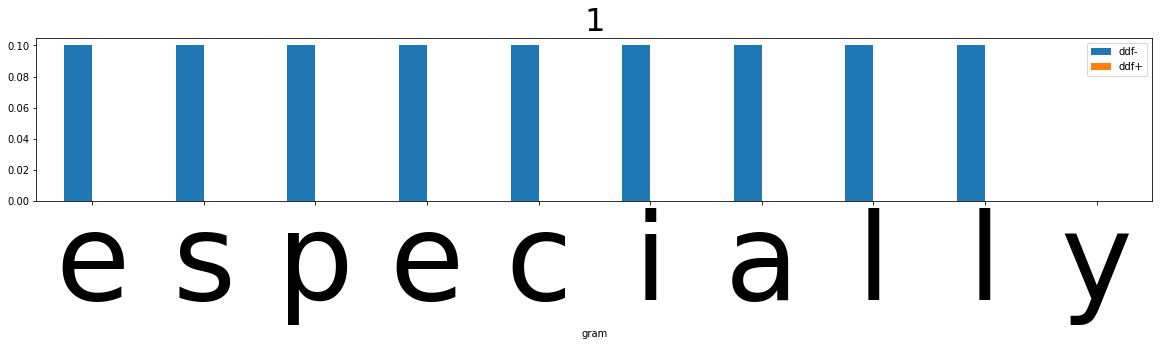

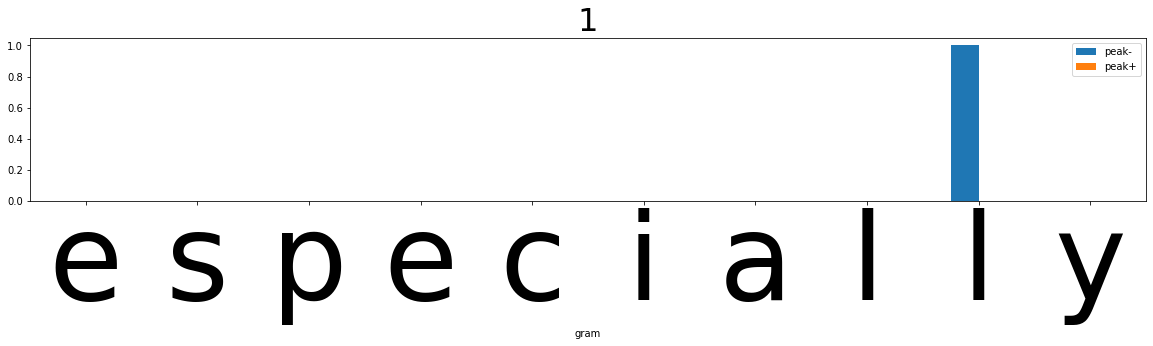

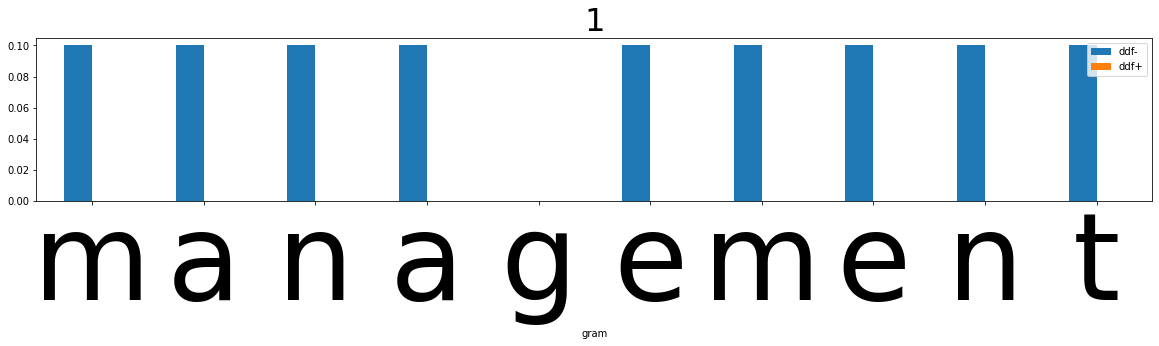

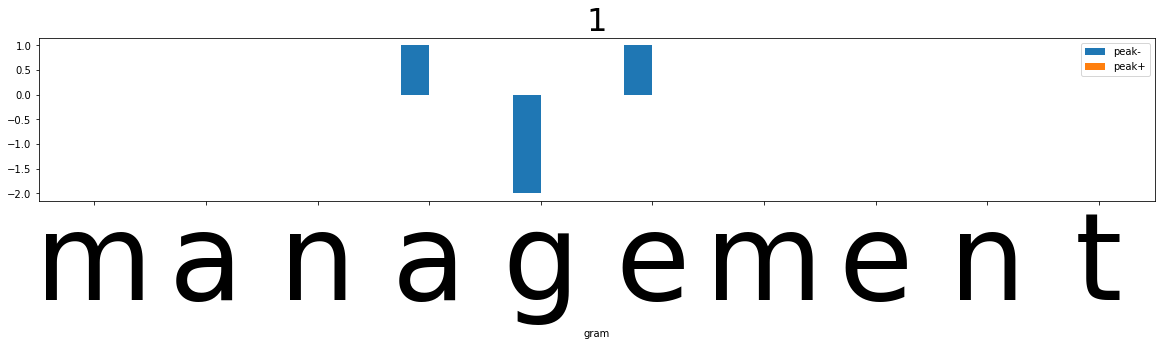

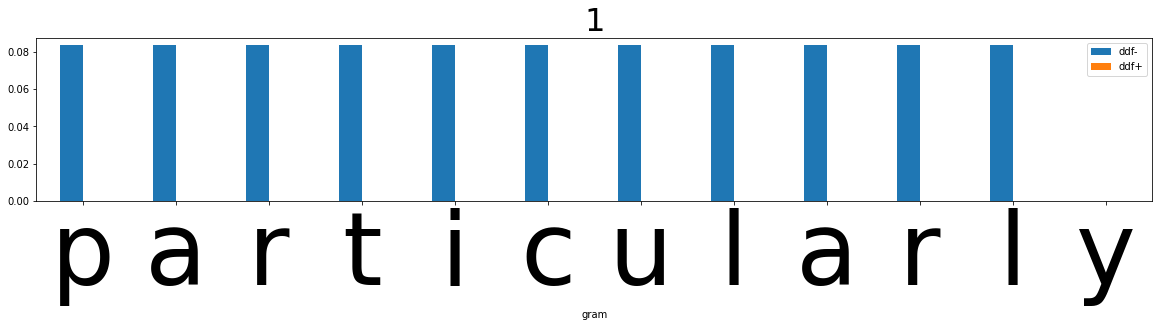

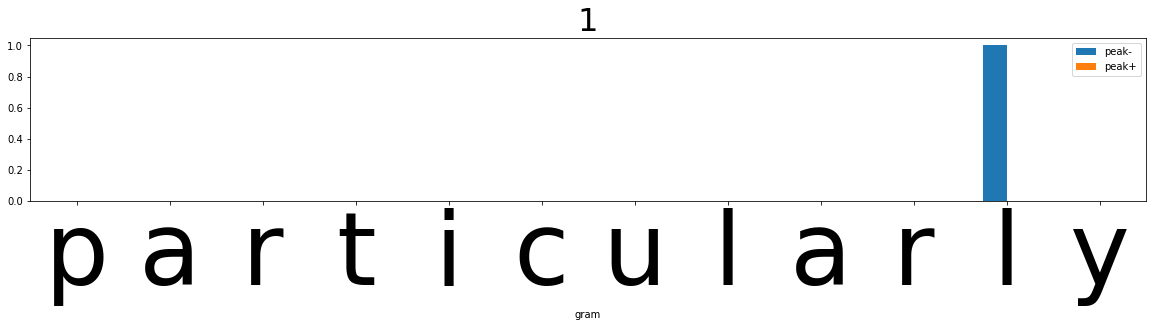

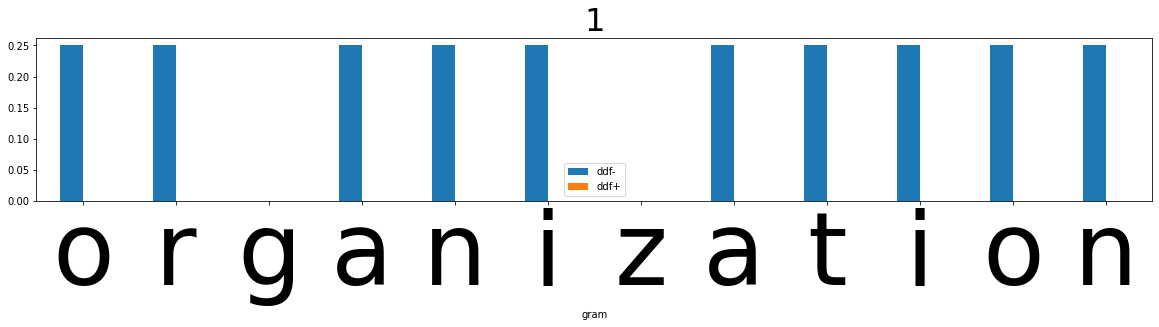

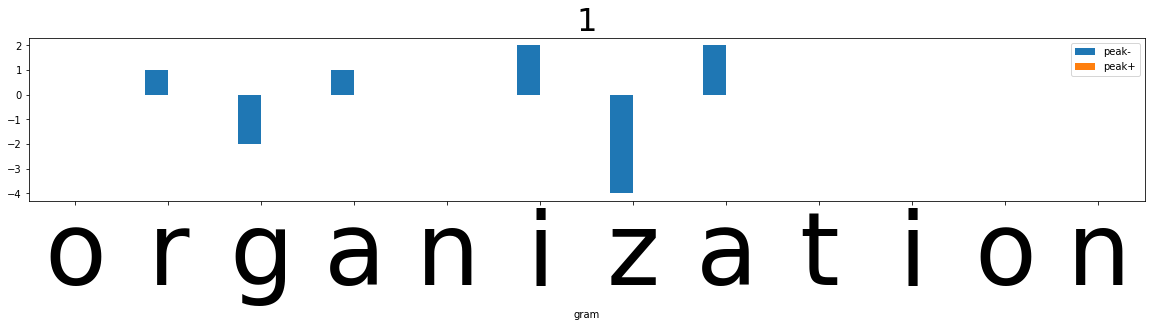

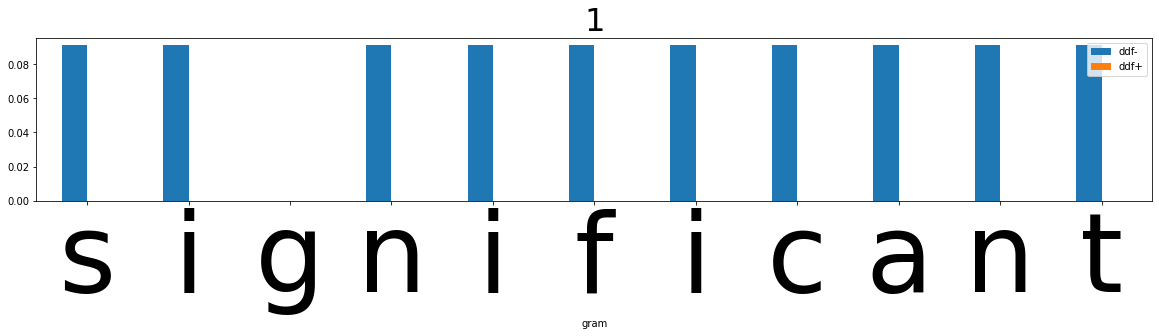

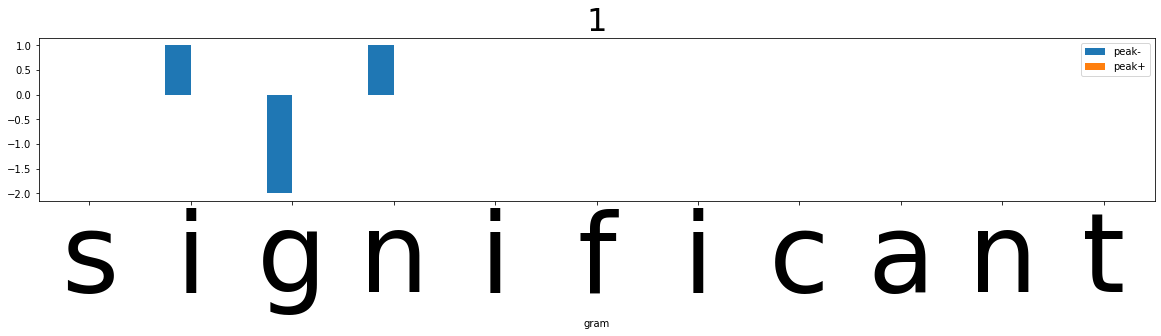

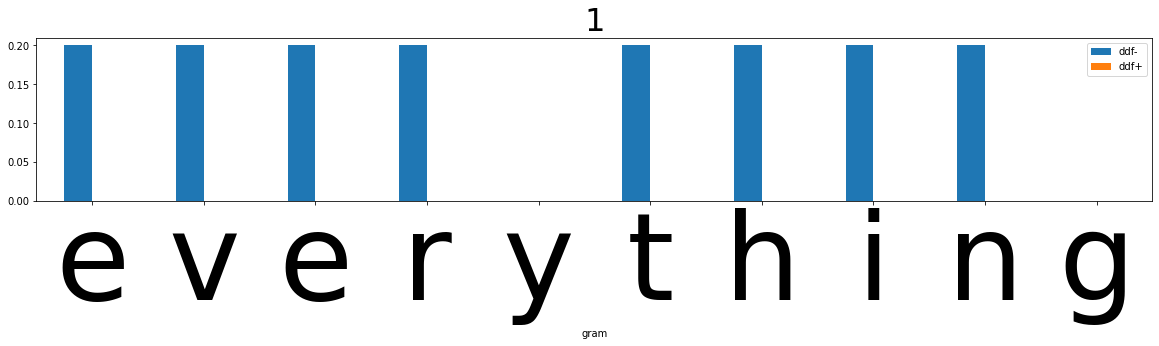

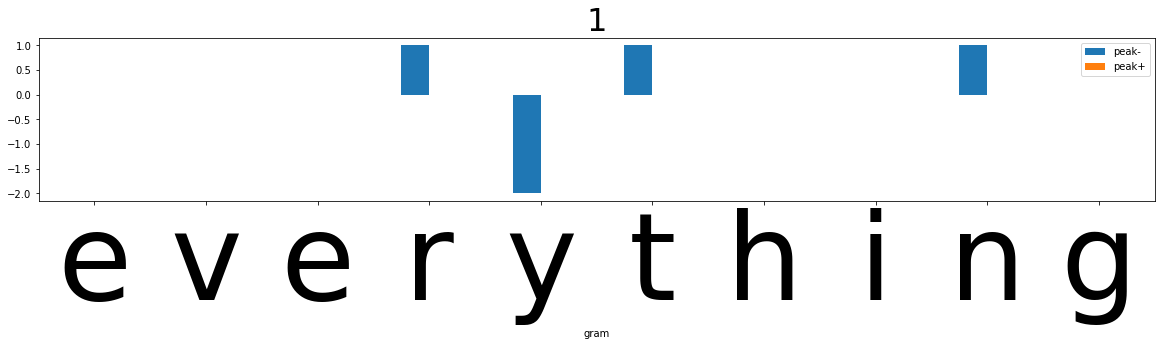

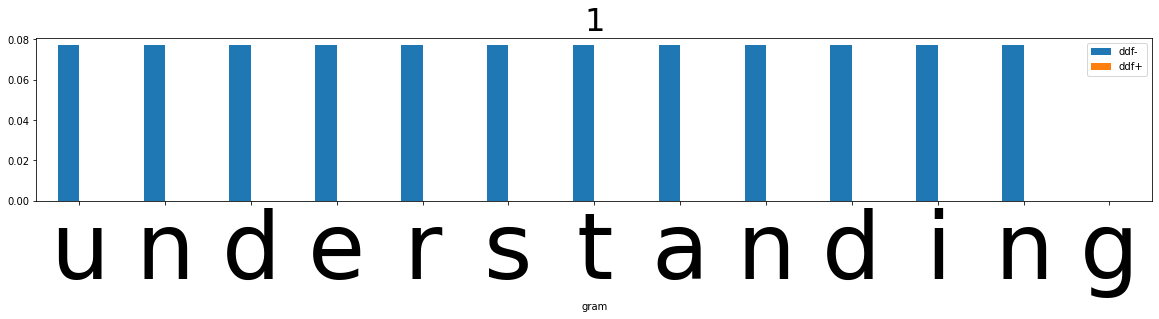

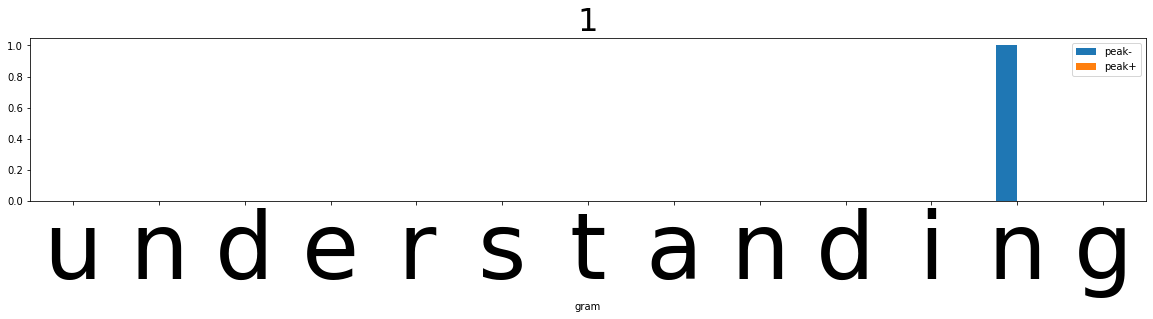

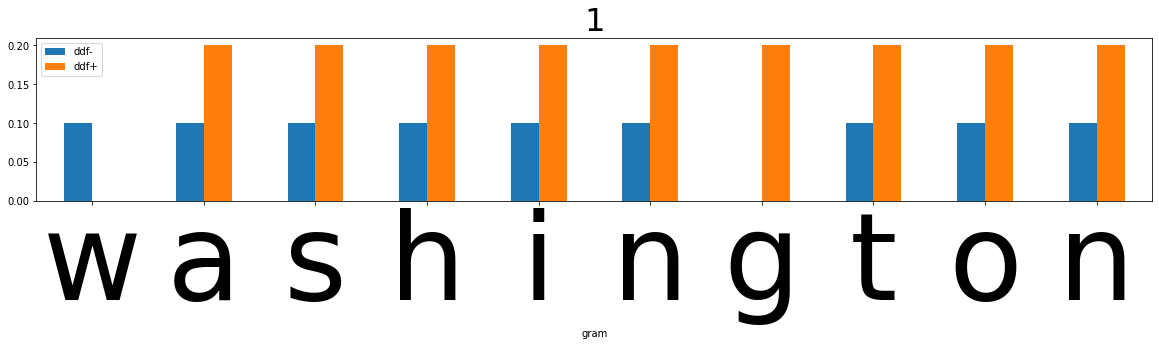

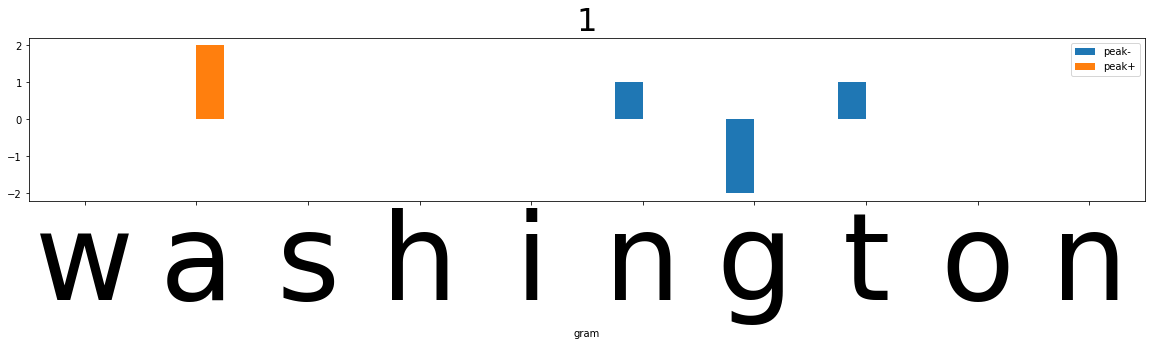

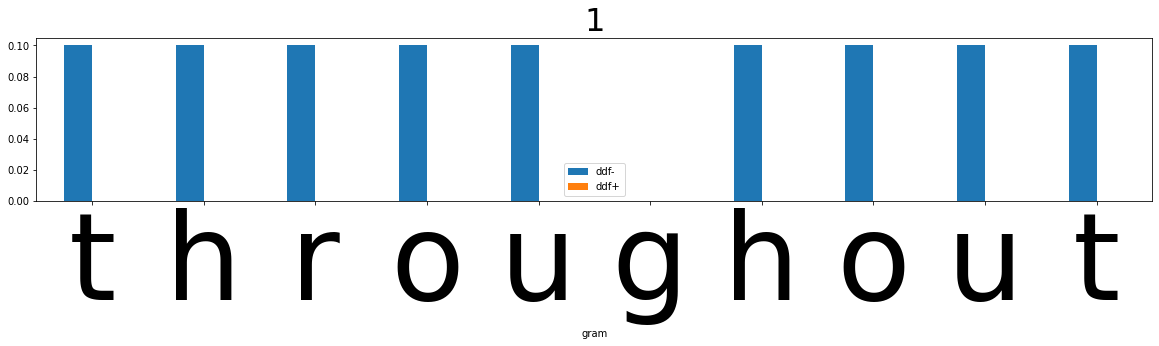

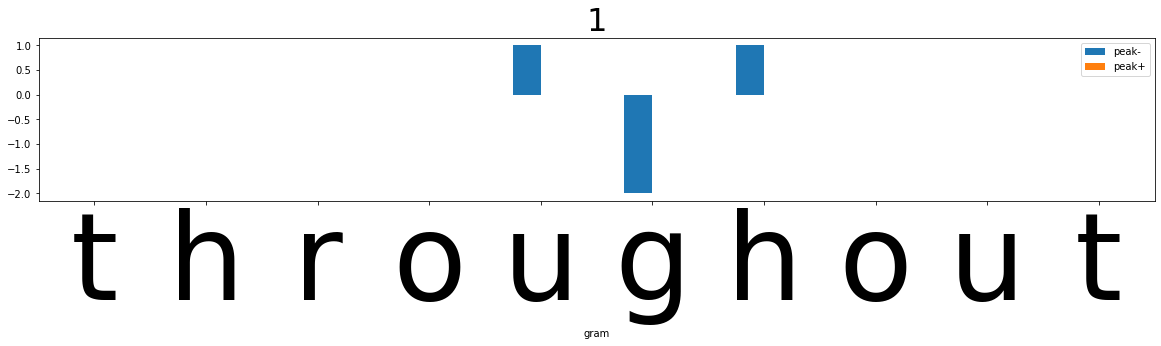

In [48]:
n = 1
print('ref','\t','auto')
tokenizer = FreedomBasedTokenizer(lex_en_base,'peak-','peak+')
cnt = 0
for i in range(0,len(en_lex_texts_no_count)):
    text = en_lex_texts_no_count[i]
    tokenizer.set_options(nlist = [n], threshold=0.5)
    t0 = en_ref_tokenizer.tokenize(text)
    t1 = tokenizer.tokenize(text)
    if len(t1) < 2 or len(text) < 10:
        continue
    #assert t0 == t1
    print(t0,'\t',t1)
    #print(t1)
    #print()
    df = profile_freedoms_ex_df(lex_en_base.model,text,n)
    plot_bars(df,'gram',['ddf-','ddf+'],title=str(n))
    plot_bars(df,'gram',['peak-','peak+'],title=str(n))
    cnt += 1
    if cnt > 10:
        break


['development']
['d', 'e', 'v', 'e', 'l', 'opm', 'e', 'nt']
['d', 'e', 'v', 'elopmen', 't']
['de', 'velopm', 'ent']
['de', 'velopm', 'ent']
['de', 'velopm', 'ent']
['de', 'velopm', 'ent']


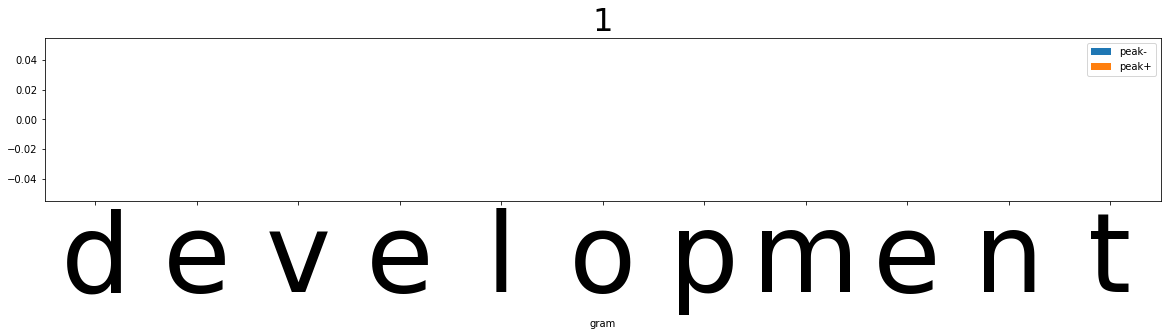

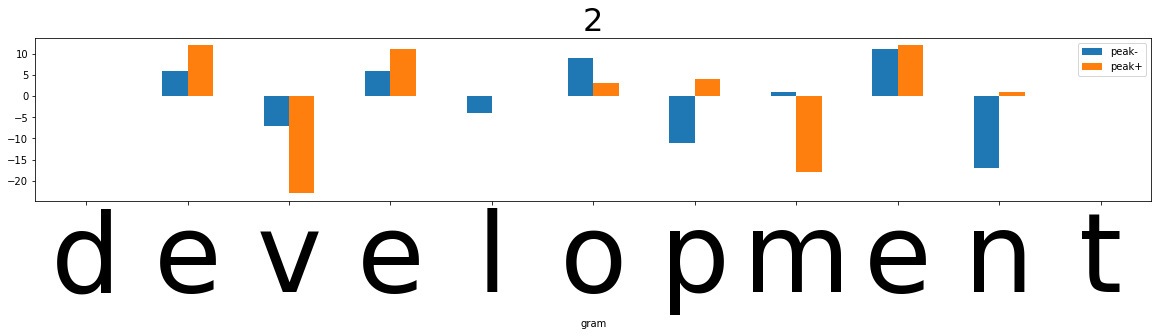

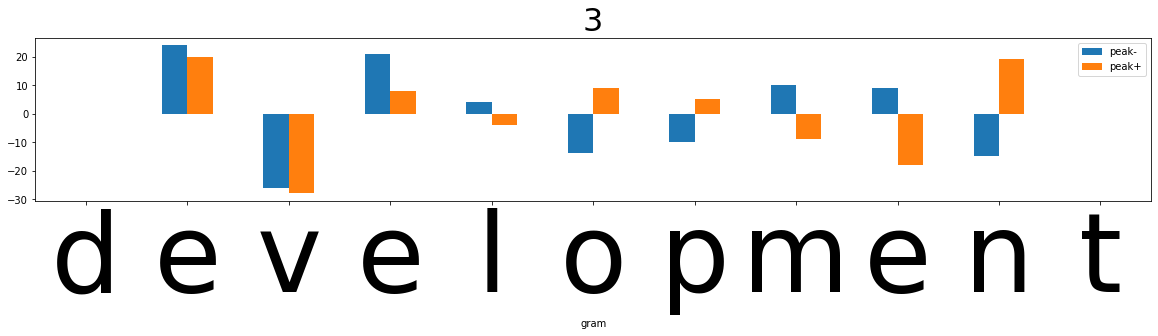

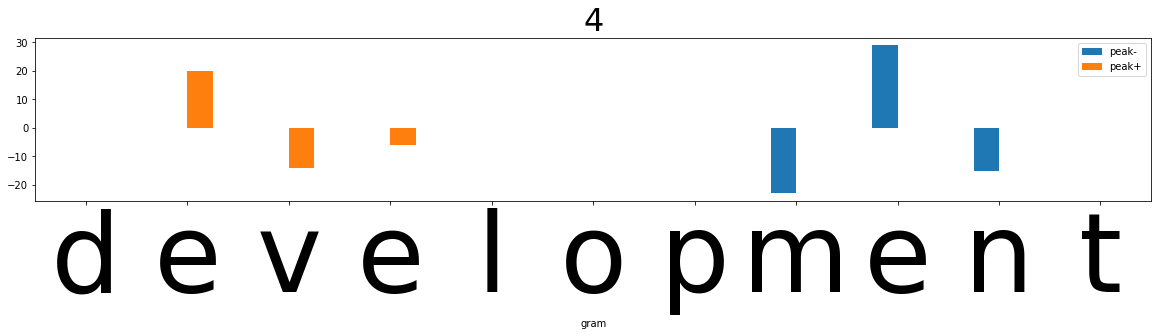

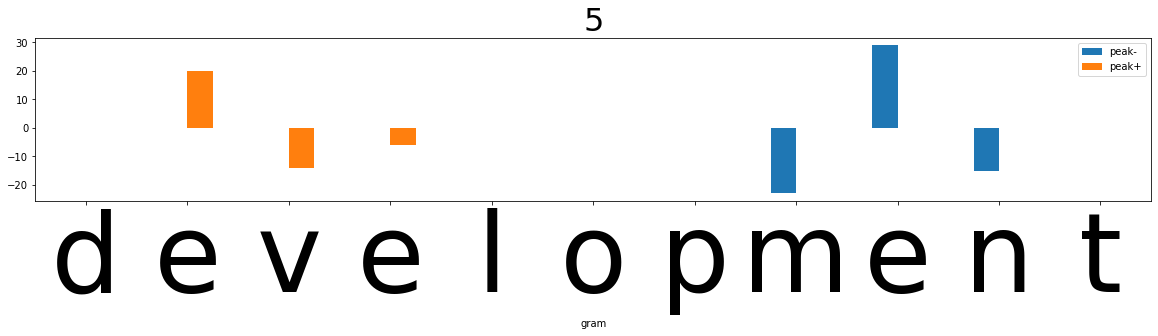

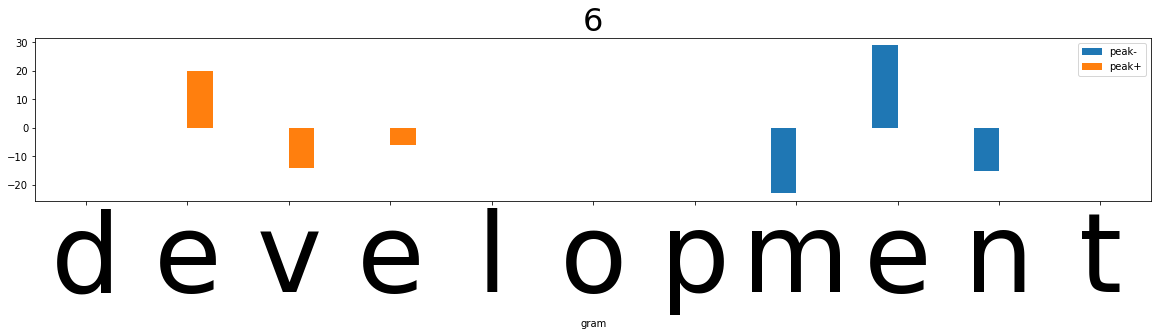

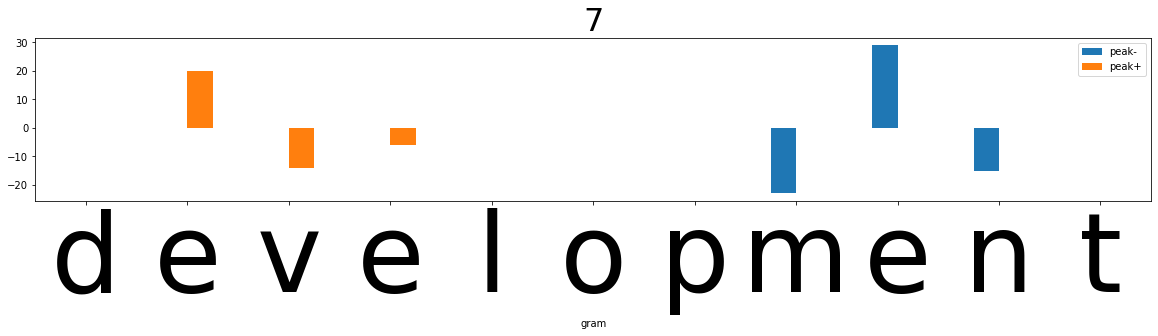

In [46]:
text = 'development'
threshold = 0.5
tokenizer = FreedomBasedTokenizer(lex_en_base,'peak-','peak+')
for n in range(1,7+1):
    tokenizer.set_options(nlist = [n], threshold=threshold)
    t1 = tokenizer.tokenize(text)
    print(t1)
    df = profile_freedoms_ex_df(lex_en_base.model,text,n)
    plot_bars(df,'gram',['peak-','peak+'],title=str(n))


['de', 'velop', 'ment']
4 0.0 ['d', 'e', 'v', 'e', 'l', 'o', 'p', 'm', 'e', 'n', 't']
4 0.1 ['de', 'velopm', 'ent']
4 0.2 ['de', 'velopm', 'ent']
4 0.3 ['de', 'velopm', 'ent']
4 0.4 ['de', 'velopm', 'ent']
4 0.5 ['de', 'velopm', 'ent']
4 0.6 ['de', 'velopm', 'ent']
4 0.7 ['de', 'velopm', 'ent']
4 0.8 ['de', 'velopm', 'ent']
4 0.9 ['de', 'velopm', 'ent']
1 0.5 ['development']
2 0.5 ['d', 'e', 'v', 'e', 'l', 'opm', 'e', 'nt']
3 0.5 ['d', 'e', 'v', 'elopmen', 't']
4 0.5 ['de', 'velopm', 'ent']
5 0.5 ['de', 'velopm', 'ent']
6 0.5 ['de', 'velopm', 'ent']
7 0.5 ['de', 'velopm', 'ent']


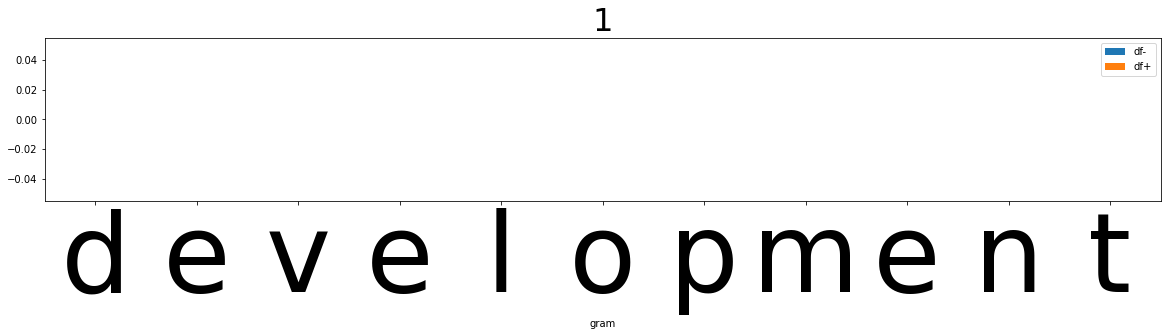

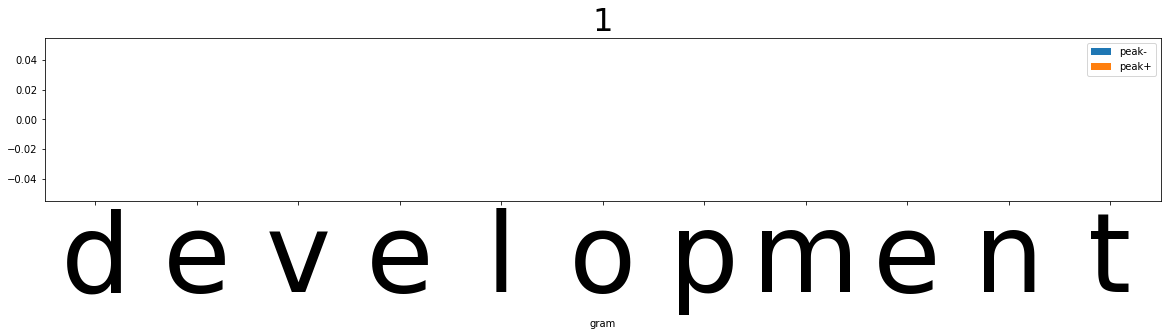

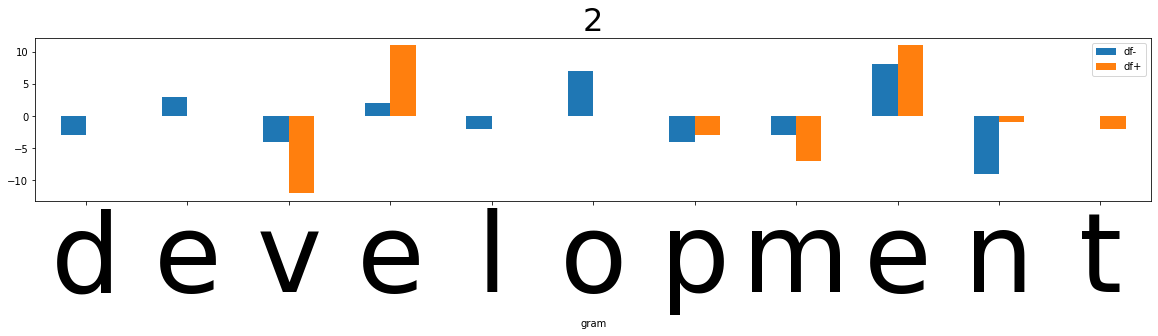

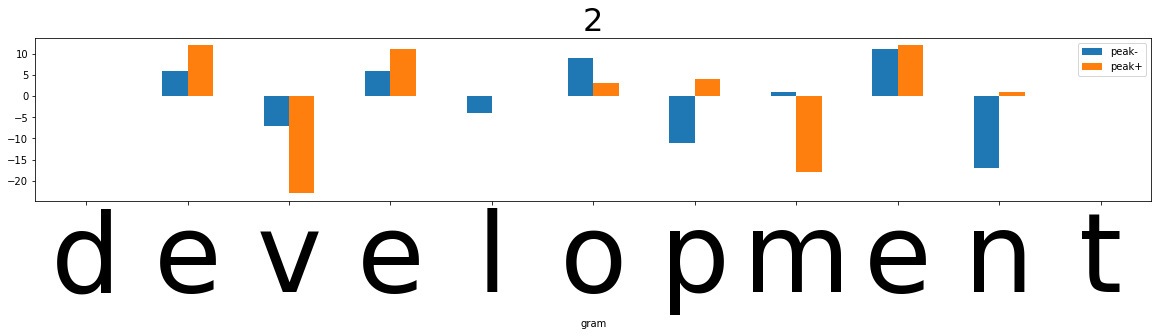

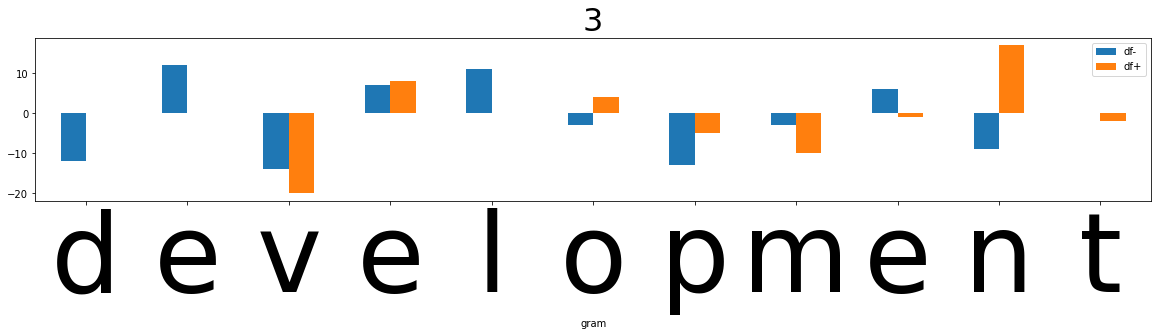

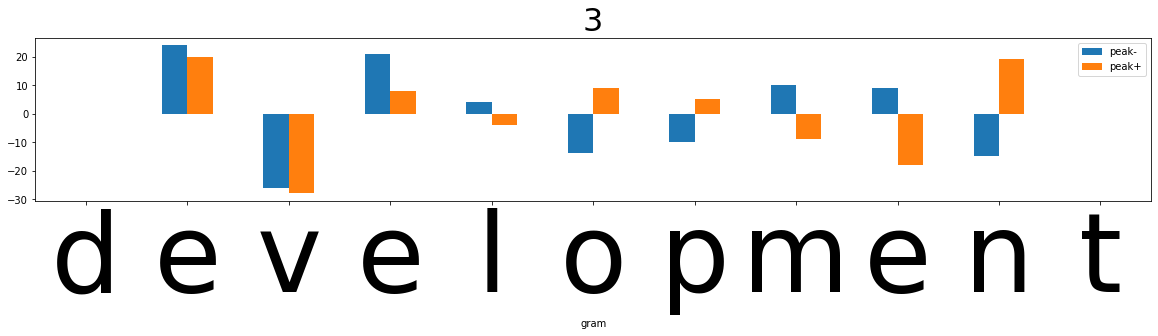

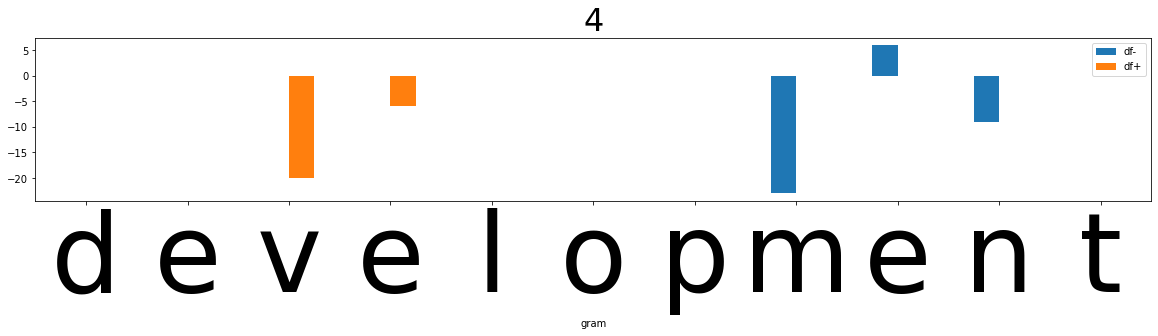

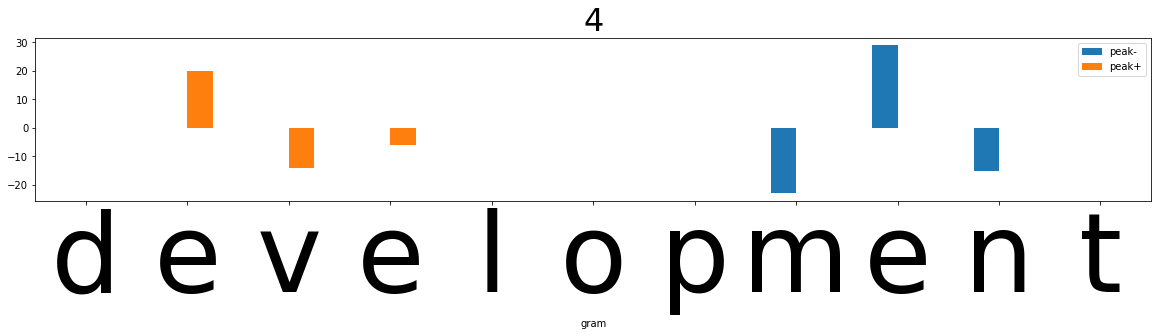

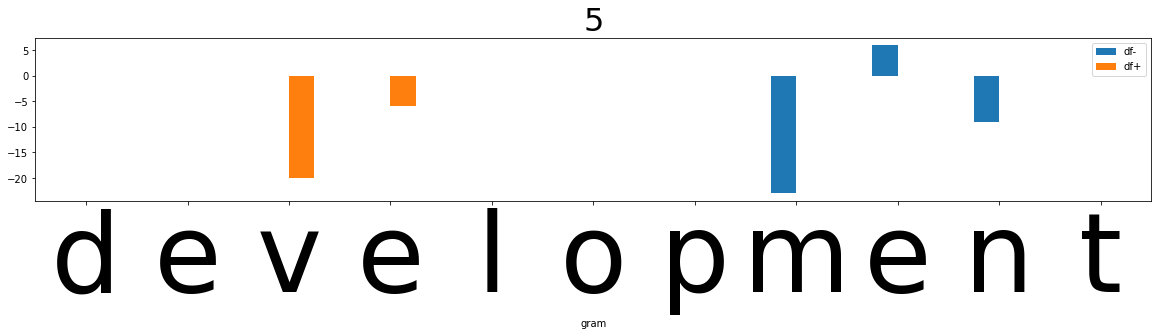

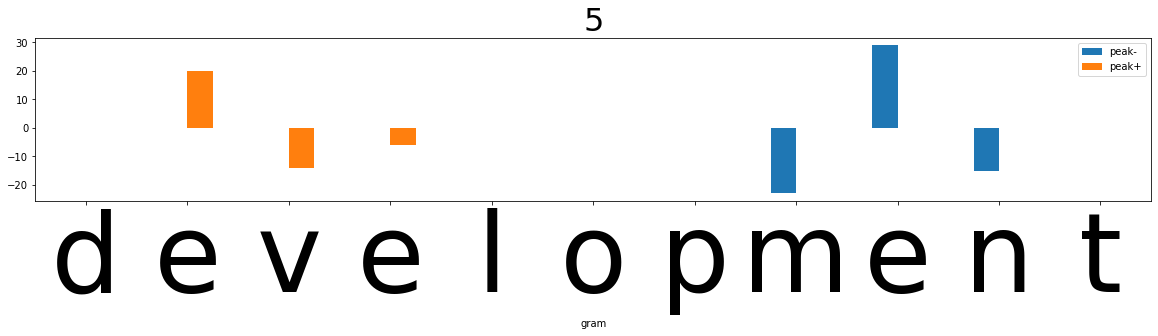

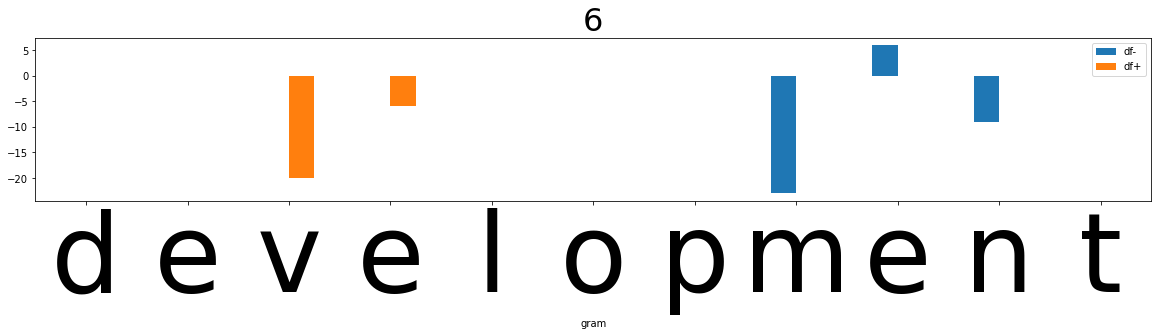

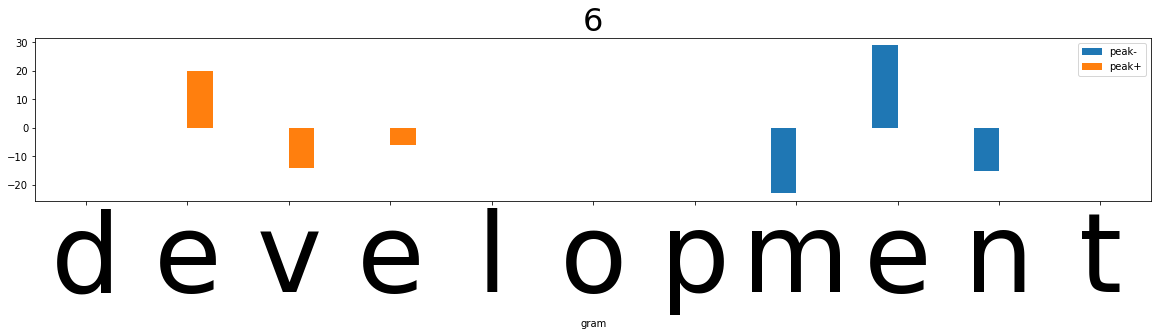

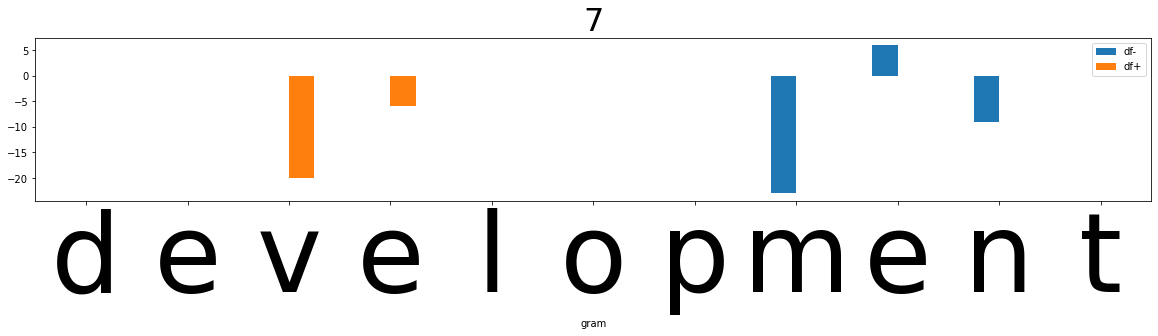

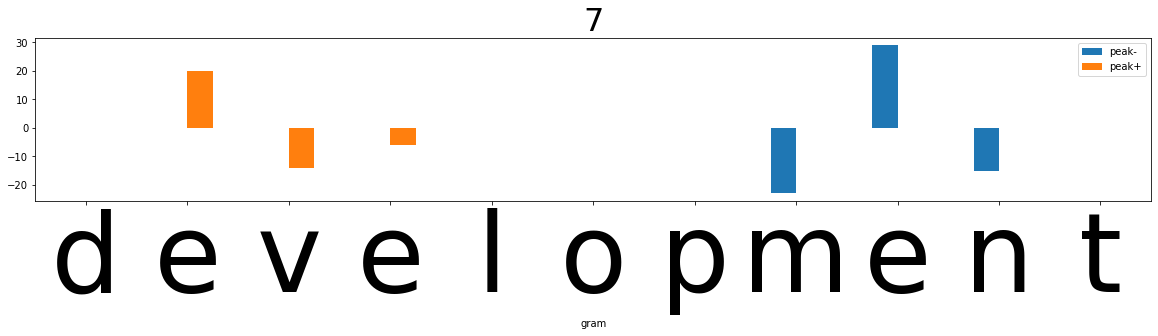

In [56]:
text = 'development'
tokenizer = FreedomBasedTokenizer(lex_en_base,'peak-','peak+')

print(en_ref_tokenizer.tokenize(text))

n = 4
for threshold in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    tokenizer.set_options(nlist = [n], threshold=threshold)
    t1 = tokenizer.tokenize(text)
    print(n,threshold,t1)

threshold = 0.5
for n in range(1,7+1):
    tokenizer.set_options(nlist = [n], threshold=threshold)
    t1 = tokenizer.tokenize(text)
    print(n,threshold,t1)
    df = profile_freedoms_ex_df(lex_en_base.model,text,n)
    plot_bars(df,'gram',['df-','df+'],title=str(n))
    plot_bars(df,'gram',['peak-','peak+'],title=str(n))


In [ ]:
#TODO word disassembler based on suffixes and prefixes
#TODO cache word morhpemezation for better perfromance

#TODO word dsassembler based on full list of morphemes

#TODO experiment en (PROGRESS)

#TODO experiment ru

#TODO
#https://colingoldberg.github.io/morphemes/morpheme/dataset/2019/06/03/morpheme-dataset.html
#https://github.com/colingoldberg/morphemes

